# X-class Day 4: Details Details

Using RandomForestClassifier from scikit learn to train a classifier on photon event metadata. 

Input files: 
 - event list 
 - region files for training sets (bkg and src)
 - region files for testing sets (bkg and src)
 
 This notebook updates by performance by exploring the parameters. 

In [1]:
# %load class2.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
#import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
from astropy.table import Table, vstack
from sklearn.ensemble import RandomForestClassifier

In [2]:
def parse_region_file(reg_file): 
    """parses a region file for coordinate positions and radii
    
    Region file syntax: 
        # Region file format: CIAO version 1.0
        circle(3448.493,4095.1661,20.325203)
        circle(3811.8263,4301.8327,20.325203)
        ...
        
    which is: generic_shape(x,y,radius)
    """
    f = open(reg_file,'r')
    x,y,r =[],[],[]
    for l in f.readlines(): 
        if l[0] not in ['#','\n',' ']:
            xt,yt,rt = l.split('(')[1].split(')')[0].split(',')
            x.append(float(xt));y.append(float(yt));r.append(float(rt))
    return np.asarray(x),np.asarray(y),np.asarray(r)

def get_events(evt,x,y,r=10.0):
    """get events from a position and calculate offset
    
    Event list and position x,y and radius are used to 
    trim a new event list into only the region of interest. 
    
    Non-offset x,y values are removed from new event list. 
    
    """
    revt = np.sqrt((evt['x']-x)**2+(evt['y']-y)**2)
    tevt = copy.copy(evt[revt<=r])
    tevt['xoff'] = tevt['x']-x
    tevt['yoff'] = tevt['y']-y
    del tevt['x']
    del tevt['y']
    return tevt

def merge_pos(evt,x,y,lab,r=10.0): 
    """Merges the x,y region of interests and associated labels. 
    
    Full event list is queryed for list of x,y and lab and new merged 
    products are returned. 
    """
    for i in range(len(x)): 
        if (i == 0): 
            mevt = get_events(evt,x[i],y[i],r)
            levt = np.zeros(len(mevt))
            levt[:] = lab[i]
        else:
            tmpevt = get_events(evt,x[i],y[i],r)
            tmplevt = np.zeros(len(tmpevt))
            tmplevt[:] = lab[i] 
            mevt = vstack([mevt,tmpevt])
            levt = np.hstack([levt,tmplevt])
    return mevt,levt

def build_rfc(evt,lab,rfc = None):
    """Build and fit random forest classifier. 
    
    Generates RFC if rfc is None, otherwise can use user-defined rfc. 
    
    """
    if (rfc is None): 
        rfc = RandomForestClassifier(n_estimators=200,oob_score=True)
    X = copy.copy(evt.to_pandas())
    Y = copy.copy(lab)
    rfc.fit(X.values,Y)
    return rfc,X.values,Y

def do_rfc(evt,rfc,output=False): 
    """Classify event list. 
    """
    X = copy.copy(evt.to_pandas())
    Y = rfc.predict(X.values)
    fsrc,fbkg,nevt = float(len(np.where(Y==1)[0]))/len(Y),float(len(np.where(Y==0)[0]))/len(Y),len(Y)
    if (output): print "{0:0.1f} {1:0.1f} ({2})".format(100.*fbkg,100.*fsrc,nevt)
    return Y, np.array([fsrc,fbkg,nevt])  

In [3]:
# read all events 
e = Table.read('Data/evt_1229.fits',hdu=1)
# rid ec of bad columns
ec = copy.copy(e)
badcols = ['status','ccd_id','expno','node_id','chipx','chipy','tdetx','tdety','detx','dety','pi','pha']
for bc in badcols: 
    del ec[bc]

In [4]:
# read region positions:
b1x,b1y,b1r = parse_region_file('Data/b1_1229.reg')
b2x,b2y,b2r = parse_region_file('Data/b2_1229.reg')
s1x,s1y,s1r = parse_region_file('Data/src1_1229.reg')
s2x,s2y,s2r = parse_region_file('Data/src2_1229.reg')

In [5]:
# using b1,s1 as training, b2,s2 as
trnx,trny = np.hstack((s1x,b1x)),np.hstack((s1y,b1y))
trnl = np.hstack((np.ones(len(s1x)),np.zeros(len(b1x))))

Want to see how the region of interest radius influences the classifier. 

Running a series of radii:

In [6]:
r = np.arange(30.0,2.0,-1.0)

Information we want to collect are the classifiers (len(r)), 6 source results: BG/SRC/N, 8 bkgrd results: BG/SRC/N

In [10]:
rfc_lst = []
rfc_src = np.zeros((len(r),len(s2x),3))
rfc_bkg = np.zeros((len(r),len(b2x),3))
rfc_esrc = np.zeros((len(r),len(s2x)))
rfc_ebkg = np.zeros((len(r),len(b2x)))

In [11]:
for j in range(len(r)): 
    trne,trnlab = merge_pos(ec,trnx,trny,trnl,r=r[j])
    rfc,X,Y = build_rfc(trne,trnlab) 
    rfc_lst.append(rfc)
    # print "OOB Score: {0}".format(rfc.oob_score_)
    # print sorted(zip(trne.colnames,rfc.feature_importances_),key=lambda q: q[1],reverse=True)
    # sources
    for i in range(len(s2x)): 
        srclp,srca = do_rfc(get_events(ec,s2x[i],s2y[i]),rfc)
        rfc_src[j,i,:] = srca
        rfc_esrc[j,i] = np.sqrt(1+srca[0])/np.sqrt(srca[0]*srca[2])
    # bg
    for i in range(len(b2x)): 
        bkglp,bkga = do_rfc(get_events(ec,b2x[i],b2y[i]),rfc)
        rfc_bkg[j,i,:] = bkga
        rfc_ebkg[j,i] = np.sqrt(1+bkga[1])/np.sqrt(bkga[1]*bkga[2])

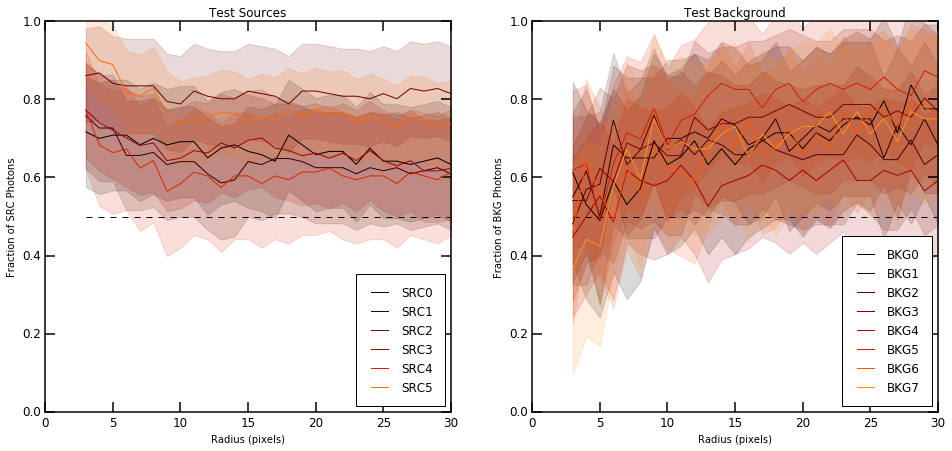

In [12]:
f = plt.figure(num=1,figsize=(16,7))
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)
cmap = mpl.cm.get_cmap('gist_heat')
for i in range(len(s2x)): 
    thiscolor = cmap(float(i)/(len(s2x)+1))
    ax1.fill_between(r,rfc_src[:,i,0]+rfc_esrc[:,i],rfc_src[:,i,0]-rfc_esrc[:,i],
                    color=thiscolor,zorder=0,alpha=0.15)
    ax1.plot(r,rfc_src[:,i,0],'-',color=thiscolor,label='SRC{0}'.format(i),zorder=10)    
for i in range(len(b2x)):
    thiscolor = cmap(float(i)/(len(b2x)+1))
    ax2.fill_between(r,rfc_bkg[:,i,1]+rfc_ebkg[:,i],rfc_bkg[:,i,1]-rfc_ebkg[:,i],
                     color=thiscolor,zorder=0,alpha=0.15)
    ax2.plot(r,rfc_bkg[:,i,1],'-',color=thiscolor,label='BKG{0}'.format(i))
ax1.hlines(0.5,min(r),max(r),colors='k',linestyles='--')
ax2.hlines(0.5,min(r),max(r),colors='k',linestyles='--')
ax1.set_ylim(0,1); ax1.set_title('Test Sources')
ax1.set_ylabel('Fraction of SRC Photons'); ax1.set_xlabel('Radius (pixels)')
ax2.set_ylim(0,1); ax2.set_title('Test Background')
ax2.set_ylabel('Fraction of BKG Photons'); ax2.set_xlabel('Radius (pixels)')
ax1.legend(loc='lower right'); ax2.legend(loc='lower right')
plt.show()
